This notebook is used for calculation of centrality & clustering coefficients and number of 1st degree TF neighbors

In [2]:
import pandas as pd
import csv
import numpy as np
import scipy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=40,20
import matplotlib.mlab as mlab
from IPython.display import display
pd.options.display.max_columns = None
from numpy import random
from statsmodels import robust
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import itertools
import networkx as nx


In [3]:
tf_human  = pd.read_csv('trrust_rawdata.human.tsv',sep='\t',header=None,
                        names = ['TF','Target','ModeofRegulation','PMID'])
tf_human_list = tf_human['TF'].drop_duplicates().tolist()

In [5]:
lung_network_df = pickle.load( open( "Lung_network.p", "rb" ) )

In [ ]:
lung_network_df.head()

In [ ]:
lung_network_df.shape

In [ ]:
lung_network_df = lung_network_df.sort_values('Ratio_val')

In [ ]:
x = lung_network_df[lung_network_df['Conditional_Ratio'] < 1 ]
x.shape

In [6]:
lung_network_df.hist(column = 'Conditional_Ratio',bins = 200,range = (0.85,1.2))

KeyError: "['Conditional_Ratio'] not in index"

In [7]:
def iftf_func(gene, tf_list = tf_human_list):
    if g in tf_list:
        return 1
    else:
        return 0

In [8]:
# Clustering is based on this - https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering
#
def iftf_func(gene, tf_list = tf_human_list):
    if gene in tf_list:
        return 1
    else:
        return 0
    
def tissue_graph(tissue_sample_df, ratio_val_threshold = 0.5, tf_list = tf_human_list ):
    tissue_df = tissue_sample_df[tissue_sample_df['Ratio_val'] > ratio_val_threshold]
    G = nx.from_pandas_edgelist(tissue_df, 'Gene1', 'Gene2', 'PPI_val')
    clustering_dict = nx.clustering(G)
    centrality_dict = nx.degree_centrality(G)
    gene_list = list(clustering_dict.keys())
    print(len(gene_list))
    gene = []
    neighbors = []
    is_tf = []
    tf_neighbors = []
    count = 0
    for g in gene_list:
        count+=1
        gene.append(g)
        neighbors.append(G.degree(g))
        is_tf.append(iftf_func(g))
        tf_connections = len(set(tf_list) & set(list(G.neighbors(g))))
        tf_neighbors.append(tf_connections)
        
        if count%1000 ==0:
            print(count)
            
    tissue_gene_graph_params = pd.DataFrame({'Gene':gene,'NumOfNeighbors':neighbors,
                                            'IsTF':is_tf,'NumOfTFNeighbors':tf_neighbors})
        
    tissue_gene_graph_params['Clustering_coeff']= tissue_gene_graph_params['Gene'].map(clustering_dict)
    tissue_gene_graph_params['Centrality_coeff']= tissue_gene_graph_params['Gene'].map(centrality_dict)
    
    return tissue_gene_graph_params

In [9]:
lung_graph_params = tissue_graph(lung_network_df)

4477
1000
2000
3000
4000


In [10]:
lung_graph_params.columns

Index(['Gene', 'IsTF', 'NumOfNeighbors', 'NumOfTFNeighbors',
       'Clustering_coeff', 'Centrality_coeff'],
      dtype='object')

In [11]:
lung_graph_params
lung_graph_params.sort_values('NumOfNeighbors',ascending = False).head(10)

,Gene,IsTF,NumOfNeighbors,NumOfTFNeighbors,Clustering_coeff,Centrality_coeff
3873,NTRK1,0,893,56,0.018817,0.199508
527,SUMO2,0,713,147,0.027927,0.159294
548,EGFR,0,627,41,0.017954,0.140080
3151,JUN,1,611,139,0.036389,0.136506
2238,ESR1,1,516,128,0.042726,0.115282
2398,XPO1,0,513,71,0.021442,0.114611
1893,SUMO1,0,492,125,0.033070,0.109920
1954,NXF1,0,427,51,0.024018,0.095398
261,CUL3,0,384,36,0.048124,0.085791
811,GRB2,0,382,35,0.033815,0.085344


In [12]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.from_pandas_edgelist(lung_network_df, 'Gene1', 'Gene2', 'PPI_val')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['PPI_val'] > 0.75]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['PPI_val'] <= 0.75]

pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=300)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=6)
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=6, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()

KeyboardInterrupt: 

In [14]:
dtg_masterlist = pd.read_csv('Disease_Tissue_Gene_masterlist_updated.csv')

In [15]:
token = ''
short_df = dtg_masterlist[dtg_masterlist['Tissue'] == 'Lung']

for index,row in short_df.iterrows():
    token = token+ ','+  row['Gene Symbols']
    
token2 = token.split(',')

In [16]:
lung_disease_genes = []
count = 0
for i in token2:
    j = i.replace(' ','')
    lung_disease_genes.append(j)
lung_disease_genes.remove('')

In [17]:
print(short_df.shape)

(137, 9)


In [18]:
lung_graph_params.head()

,Gene,IsTF,NumOfNeighbors,NumOfTFNeighbors,Clustering_coeff,Centrality_coeff
0,DRG2,0,11,1,0.200000,0.002458
1,DPM3,0,5,0,0.100000,0.001117
2,GPSM2,0,11,0,0.166667,0.002458
3,SRXN1,0,20,4,0.136842,0.004468
4,PPM1E,0,7,1,0.047619,0.001564


In [19]:
label = []

for index,row in lung_graph_params.iterrows():
    gene = row['Gene']
    if gene in lung_disease_genes:
        label.append('P')
    else:
        label.append('U')

In [20]:
label.count('P')

61

In [21]:
lung_graph_params['Pos_Unlab'] = label

In [16]:
lung_graph_params[lung_graph_params['Pos_Unlab'] == 'P']

,Gene,IsTF,NumOfNeighbors,NumOfTFNeighbors,Clustering_coeff,Centrality_coeff,Pos_Unlab
6,AASS,0,4,1,0.000000,0.000894,P
48,PHB,0,102,20,0.103863,0.022788,P
176,CFTR,0,106,3,0.037528,0.023682,P
182,LBR,0,31,6,0.233990,0.006926,P
337,IRF1,1,24,13,0.173913,0.005362,P
413,NQO2,0,12,1,0.022222,0.002681,P
441,SMAD4,1,155,65,0.050826,0.034629,P
450,AKT1,0,179,39,0.047702,0.039991,P
521,TLR2,0,25,3,0.083004,0.005585,P
590,EDNRB,0,20,2,0.031579,0.004468,P


In [22]:
lung_graph_params.shape

(4477, 7)

[Text(0,0,'U'), Text(0,0,'P')]

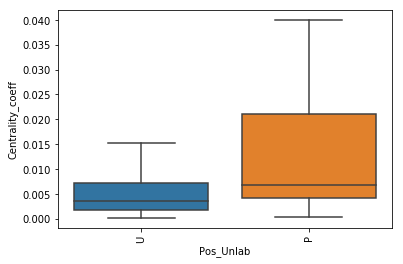

In [23]:
ax = sns.boxplot( y="Centrality_coeff",x='Pos_Unlab', data=lung_graph_params,showfliers=False)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:

H = G.subgraph(list(lung_graph_params['Gene']))
nx.draw(H)